Populating the interactive namespace from numpy and matplotlib


/Users/vale/anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['i0']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


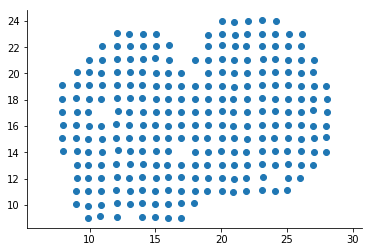

In [49]:
%pylab inline
import pandas as pd

rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False

results = pd.read_csv('../MouseOB/MOB_final_results.csv', index_col=0)
ms_results = pd.read_csv('../MouseOB/MOB_MS_results.csv', index_col=0)
sample_info = pd.read_csv('../MouseOB/MOB_sample_info.csv', index_col=0)

df = pd.read_csv('../MouseOB/data/Rep11_MOB_0.csv', index_col=0)
df = df.T[df.sum(0) >= 3].T  # Filter practically unobserved genes
sample_info = sample_info.query('total_counts > 10')  # Remove empty features
df = df.loc[sample_info.index]
dfm = np.log10(df + 1)

plt.axis('equal')
plt.scatter(sample_info.x, sample_info.y);

In [50]:
X = sample_info[['x', 'y']]

In [51]:
peak = np.array([[14., 15.]])

In [52]:
def rbf_kernel_pred(X1, X2, l):
    X1sq = np.sum(np.square(X1), 1)
    X2sq = np.sum(np.square(X2), 1)
    R2 = -2. * np.dot(X1, X2.T) + (X1sq[:, None] + X2sq[None, :])
    R2 = np.clip(R2, 1e-12, np.inf)
    
    return np.exp(-R2 / (2 * l ** 2))

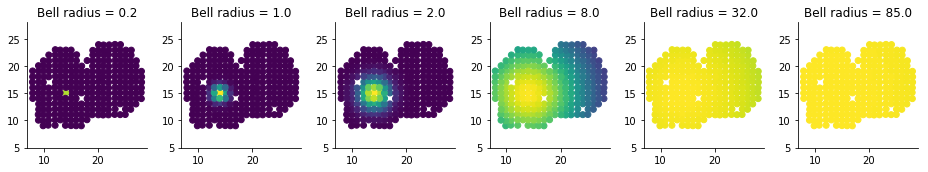

In [118]:
figsize(13, 2.5)

for i, radius in enumerate([0.2, 1., 2., 8., 32., 85.]):
    plt.subplot(1, 6, i + 1)

    h = rbf_kernel_pred(peak, X, radius).T

    plt.axis('equal')
    plt.scatter(X.x, X.y, c=h[:, 0], vmin=0, vmax=1);

    plt.title('Bell radius = {}'.format(radius))

plt.tight_layout()
plt.savefig('basis_function_examples.pdf', bbox_inches='tight')

In [62]:
import SpatialDE
from scipy import stats

In [209]:
SpatialDE.base.get_l_limits??

In [63]:
l_min, l_max = SpatialDE.base.get_l_limits(X)
l_min, l_max = l_min / 2, l_max * 2

In [66]:
l_min, l_max

(0.20100062188959059, 85.909863554774645)

In [137]:
sim_expr = pd.DataFrame(index=range(X.shape[0]))
ground_truth = pd.DataFrame(index=['s2_n', 'l', 's2_s', 'FSV'])
j = 0

s2s = 10 ** np.random.uniform(-3, 1, 200)
for l in np.logspace(np.log10(l_min), np.log10(l_max), 15):
    print(l)
    h = rbf_kernel_pred(peak, X, l)[0]
    s2_s = h.var()
    for s2 in s2s:
        gex = h + stats.norm.rvs(scale=s2, size=(X.shape[0]))
        
        sim_expr[j] = gex
        s2_n = s2 ** 2
        FSV = s2_s / (s2_s + s2_n)
        ground_truth[j] = [s2 ** 2, l, s2_s, FSV]
        
        j += 1
        
ground_truth = ground_truth.T

0.20100062189
0.30982392107
0.477565000369
0.736122403946
1.13466479573
1.74898113651
2.69589311962
4.15547061125
6.40527470295
9.87314021887
15.2185350827
23.4579682786
36.1582946564
55.7346764619
85.9098635548


In [138]:
ground_truth.head()

,s2_n,l,s2_s,FSV
0,0.048059,0.201001,0.002972,0.058246
1,0.012650,0.201001,0.002972,0.190263
2,19.696014,0.201001,0.002972,0.000151
3,0.000003,0.201001,0.002972,0.998824
4,0.065458,0.201001,0.002972,0.043437


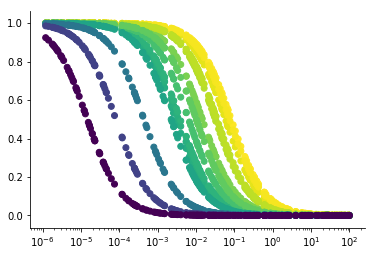

In [139]:
figsize(6, 4)
plt.xscale('log')
plt.scatter(ground_truth.s2_n, ground_truth.FSV, c=np.log(ground_truth.s2_s));

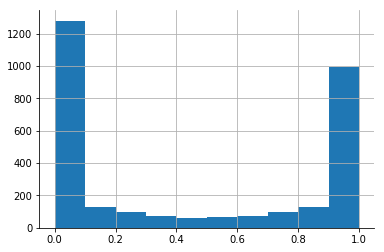

In [140]:
ground_truth.FSV.hist()

In [141]:
results = SpatialDE.run(X, sim_expr)
results.loc[results.pval < 1e-16, 'pval'] = 1e-16

INFO:root:Performing DE test
INFO:root:Pre-calculating USU^T = K's ...
INFO:root:Done: 0.11s
INFO:root:Fitting gene models
INFO:root:Model 1 of 10
INFO:root:Model 2 of 10                             
INFO:root:Model 3 of 10                             
INFO:root:Model 4 of 10                             
INFO:root:Model 5 of 10                             
INFO:root:Model 6 of 10                             
INFO:root:Model 7 of 10                             
INFO:root:Model 8 of 10                             
INFO:root:Model 9 of 10                             
INFO:root:Model 10 of 10                            


In [142]:
results = results.sort_values('g')

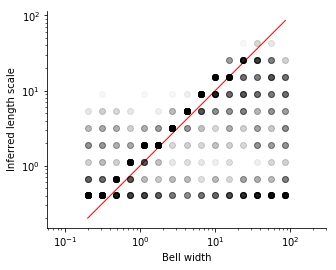

In [143]:
figsize(5, 4)
plt.loglog()
plt.plot([l_min, l_max], [l_min, l_max], c='r', lw=1, zorder=-1)
plt.scatter(ground_truth.l, results.l, alpha=0.03, c='k');
plt.axis('equal');
plt.xlabel('Bell width')
plt.ylabel('Inferred length scale');

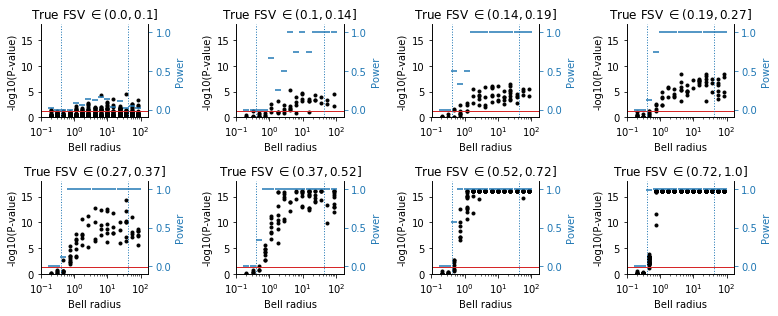

In [206]:
figsize(11, 4.5)
rcParams['axes.spines.right'] = True

N = 8
irvl = np.logspace(-1, 0, N)
irvl = np.insert(irvl, 0, 0.)
for i in range(N):
    i0, i1 = irvl[i], irvl[i+1]
    gt_part = ground_truth.query('@i0 < FSV <= @i1')
    res_part = results.query('g in @gt_part.index')
    
    plt.subplot(2, N // 2, i + 1)
    
    plt.xscale('log')
    plt.scatter(gt_part.l,
                -np.log10(res_part.pval),
                c='k',
                marker='.');

    plt.axhline(-np.log10(0.05), lw=1, c='tab:red');
    plt.axvline(l_min * 2, c='tab:blue', lw=1, ls=':')
    plt.axvline(l_max / 2, c='tab:blue', lw=1, ls=':')
    
    plt.ylim(0, 18)
    plt.xlim(l_min / 2, l_max * 2)
    
    plt.ylabel('-log10(P-value)')
    plt.xlabel('Bell radius')

    ax2 = plt.gca().twinx()
    
    comb_part = res_part[['g', 'pval']].join(gt_part, on='g')
    comb_part['significant'] = comb_part.pval < 0.05
    sig_per_l = comb_part.groupby('l').sum()['significant']
    tot_per_l = comb_part.groupby('l').count()['significant']
    power_part = sig_per_l / tot_per_l
    plt.scatter(power_part.index, power_part, marker='_', color='tab:blue')
    plt.ylim(-0.1, 1.1)

    plt.ylabel('Power', color='tab:blue')
    ax2.tick_params('y', colors='tab:blue')
    
    plt.title('True FSV $\in ({:0.2}, {:0.2}]$'.format(i0, i1))
    
plt.tight_layout()
plt.savefig('basis_function_simulation.pdf', bbox_inches='tight')

In [208]:
comb_part.groupby('l').count()['significant']

l
0.201001      75
0.309824      76
0.477565      78
0.736122      81
1.134665      88
1.748981      99
2.695893     107
4.155471     112
6.405275     111
9.873140     101
15.218535     85
23.457968     71
36.158295     55
55.734676     43
85.909864     18
Name: significant, dtype: int64